C:\Users\nitro\AppData\Local\Temp\ipykernel_37768\3683641399.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=D

✅ Classification Report:

              precision    recall  f1-score   support

      defect       0.94      0.97      0.95        30
        good       0.97      0.95      0.96        37

    accuracy                           0.96        67
   macro avg       0.95      0.96      0.95        67
weighted avg       0.96      0.96      0.96        67



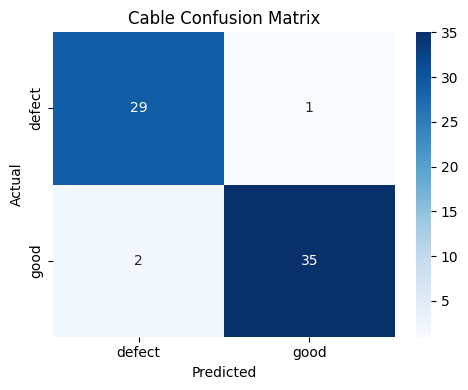

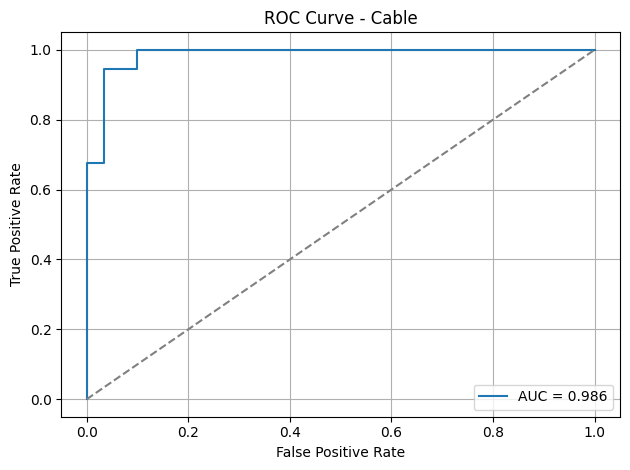

Final Test Accuracy: 95.52%
AUC Score: 0.986


In [3]:
# 📊 Cable Evaluation Notebook
import os, json
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

# === Configuration ===
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLASS_NAMES = ["defect", "good"]
MODEL_PATH = "C:/Users/nitro/defect_detection_project/models/resnet18_cable_best.pth"
TEST_PATH = "C:/Users/nitro/defect_detection_project/data\classifier_data/cable/test"
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# === Transforms & Data ===
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
test_set = datasets.ImageFolder(TEST_PATH, transform=transform)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

# === Load Model ===
model = models.resnet18(weights=None)
model.fc = torch.nn.Sequential(torch.nn.Dropout(0.5), torch.nn.Linear(model.fc.in_features, 2))
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE).eval()

# === Predict ===
y_true, y_probs = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        out = model(x)
        prob = torch.softmax(out, dim=1)[:, 1].cpu().numpy()
        y_probs.extend(prob)
        y_true.extend(y.cpu().numpy())

y_probs = np.array(y_probs)
y_pred = (y_probs > 0.5).astype(int)

# === Report ===
print("✅ Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Cable Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.savefig(os.path.join(RESULTS_DIR, "cable_confusion.png"))
plt.show()

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_true, y_probs)
auc = roc_auc_score(y_true, y_probs)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Cable"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(os.path.join(RESULTS_DIR, "cable_roc_curve.png"))
plt.show()

print(f"Final Test Accuracy: {(y_pred == y_true).mean() * 100:.2f}%")
print(f"AUC Score: {auc:.3f}")